# Road signs classifier

### 1. Download and check data¶

We will be using GTSRB dataset (German Traffic Sign Recognition Benchmark) from http://benchmark.ini.rub.de/?section=gtsrb&subsection=news.
Available datasets are train and test. We will split train set to train and validation. 

In [1]:
%load_ext autoreload
%autoreload

In [2]:
%matplotlib inline

In [3]:
#uncomment the first time
#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P source_data
#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P source_data
#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P source_data

Unzip the data to source_data. This will overwrite existing files and directories.

In [4]:
#uncomment the first time

#!unzip -o source_data/GTSRB_Final_Test_GT.zip -d source_data/test
#!unzip -o source_data/GTSRB_Final_Test_Images.zip -d source_data/test
#!unzip -o source_data/GTSRB_Final_Training_Images.zip -d source_data/train

To verify the data we will create PyTorch dataset and DataLoader. 

In [5]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import os
import pandas as pd
import PIL
from PIL import Image
from tqdm.notebook import trange, tqdm

In [6]:
torch.__version__

'1.4.0'

GTSRB train data format is directly supported by pytorch generic data loader ImageFolder: https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder 

In [7]:
# Create Dataset

#Create Transforms

transform_train = transforms.Compose([
#    transforms.Resize((32, 32)),
    transforms.Resize(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('./source_data/train/GTSRB/Final_Training/Images', transform=transform_train)

# Load Datasets
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=False, num_workers=2)

In [8]:
#Inspect classes
print(train_dataset.classes)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [9]:
#test train_dataset
assert len(train_dataset.classes) == 43, 'Incorrect number of classes, expected 43'
assert len(train_dataset) == 39209, 'Incorrect number of train files, expected 39209'
print('Train data loader correctly!')

Train data loader correctly!


GTSRB test data format is different: all image files are in one directory and there is a separate CSV file with ground truth labels, and some additinal features that we are not going to use.<br>

```csv
Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId
00000.ppm;53;54;6;5;48;49;16
00001.ppm;42;45;5;5;36;40;1
00002.ppm;48;52;6;6;43;47;38
00003.ppm;27;29;5;5;22;24;33
00004.ppm;60;57;5;5;55;52;11
```
<br>
To load this data we will define a custom Dataset implementation iterating over the data, as defined in PyTorch Dataset documentation: https://pytorch.org/docs/stable/torchvision/datasets.html <br>

There is one more custom change required: test classes use 2 digit data format and train data use 5 digits: 000nn.<br>
We will use train data format: 000nn.

In [10]:
!pygmentize GTSRB_Test.py

import torch
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class GTSRB_Test(Dataset):
    
    def __init__(self, images_dir='./source_data/test/GTSRB/Final_Test/Images', 
                 gt_csv_path='./source_data/test/GT-final_test.csv', transform=None):
        """
        Args:
            images_dir (string): Path to GTSRB images directory
            gt_csv_path: path to test ground truth csv file
            transform (callable, optional): Optional transform to be applied

        Attributes:
            classes (list): List of the class names.
            class_to_idx (dict): Dict with items (class_name, class_index).    
            
        """
        self.images_dir = images_dir
        self.gt_csv_path = gt_csv_path

        self.gt_data = pd.read_csv(gt_csv_path, header=0, sep=';')
        self.gt_data['_000ClassId']=self.gt_data.ClassId.astype(str).str.zfill(5)
        self.transform = transform
        
        classes, class

In [11]:
from GTSRB_Test import GTSRB_Test 

# Create Transform 
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Dataset
test_dataset = GTSRB_Test(
    images_dir  = './source_data/test/GTSRB/Final_Test/Images', 
    gt_csv_path = './source_data/test/GT-final_test.csv',
    transform = transform_train)

# Load Dataset
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [12]:
#inspect classes
print(test_dataset.classes)

['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


In [13]:
#test test_dataset
assert len(test_dataset) == 12630, 'Incorrect number of Validation files, expected 12630'
assert len(test_dataset.class_to_idx) == 43, 'Incorrect number of classes, expected 43'
assert len(set(train_dataset.classes) & set(test_dataset.classes)) == 43, 'Test and train classes do not match' 

print('Test data loaded correctly!')

Test data loaded correctly!


### Visualize sample train data¶

In [14]:
labels = np.zeros(len(train_dataset.classes))
progress_bar = tqdm(range(len(train_dataset)), desc='Counting files in each class')

for i in range(len(train_dataset)):
    x,y = train_dataset[i]
    labels[y] +=1
    progress_bar.update()
labels = np.array(labels, dtype=int)

In [15]:
i = 0
for label in np.nditer(labels):
    print('{}: {}'.format(i, label))
    i += 1

0: 210
1: 2220
2: 2250
3: 1410
4: 1980
5: 1860
6: 420
7: 1440
8: 1410
9: 1470
10: 2010
11: 1320
12: 2100
13: 2160
14: 780
15: 630
16: 420
17: 1110
18: 1200
19: 210
20: 360
21: 330
22: 390
23: 510
24: 270
25: 1500
26: 600
27: 240
28: 540
29: 270
30: 450
31: 780
32: 240
33: 689
34: 420
35: 1200
36: 390
37: 210
38: 2070
39: 300
40: 360
41: 240
42: 240


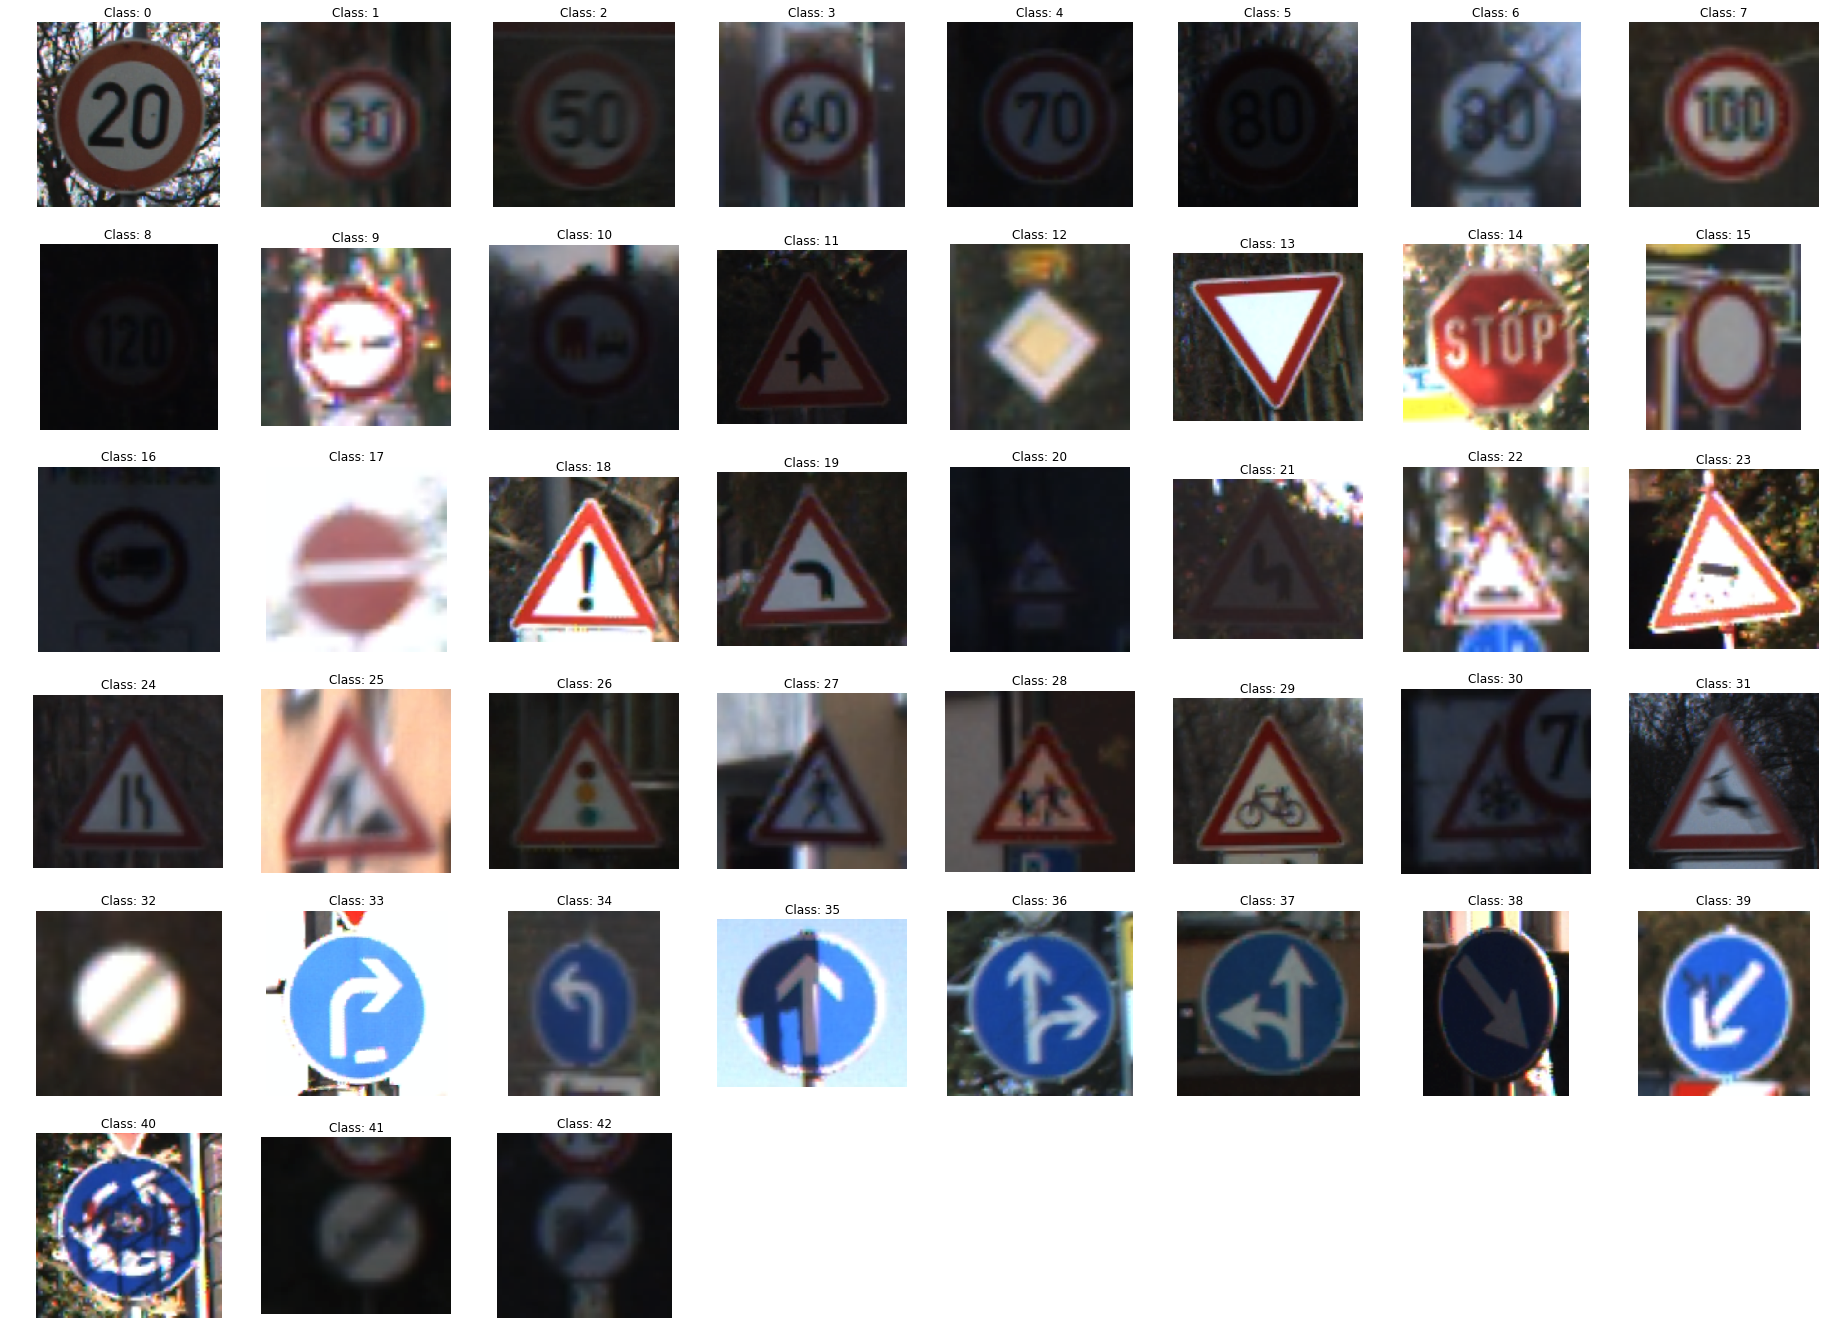

In [16]:

plt.figure(figsize=(32, 32))
offset = 0
for classId in range(len(train_dataset.classes)):
    i = random.randint(0,labels[classId])
    #offset to the right class
    i = offset + i
    plt.subplot(8, 8, classId+1)
    plt.axis('off')
    plt.title('Class: {}'.format(classId))
    img, y = train_dataset[i]
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    #plt.imshow(np.transpose(img.numpy(), (1,2,0)), interpolation='nearest')
    offset += labels[classId]   

### Data preparation - train and validation split

The data contains readme file with the following clarification:
    
    **********************************************
    Image format and naming
    **********************************************
    The images are PPM images (RGB color). Files are numbered in two parts:

       XXXXX_YYYYY.ppm

    The first part, XXXXX, represents the track number. All images of one class 
    with identical track numbers originate from one single physical traffic sign.
    The second part, YYYYY, is a running number within the track. The temporal order
    of the images is preserved.
    
Train images come from short video clips so there are multiple images of the same sign, with slight variation to angle, size etc. If images of the same sign are used to both train and validate we risk data leakage and overfitting the model. For example, if particular road sign was damaged or had a sticker, we would want the model to learn to ignore such feature. If we use images with the same defect for both training and validation we would effectively train the model to recognise this defect as integral part of the class. Such model would score low in test.

Below is an example of one such case of the sign with a sticker.

This means that train and evaluation split needs to separate images by sign ("track") name prefix. In each track size there are always 30 images.

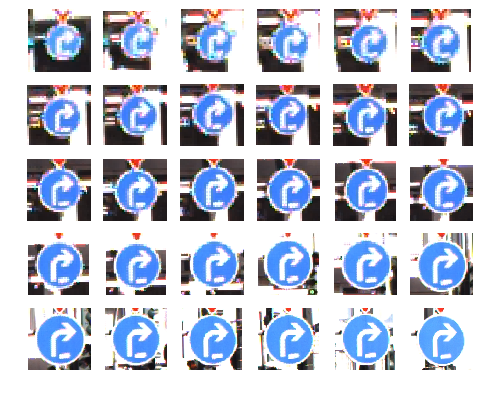

In [17]:
fig = plt.figure(figsize=(8, 8))

for i in range(30):
    plt.subplot(6,6,i+1)
    index = str(i).zfill(5)
    plt.axis('off')
    img=mpimg.imread('./source_data/train/GTSRB/Final_Training/Images/00033/00001_'+index+'.ppm')
    plt.imshow(img)


### High imbalance

The data has high imbalance so we risk that the model would favour bigger classes as more probable based on input distribution, not features. 

Smallest class: 210
Biggest class:  2250


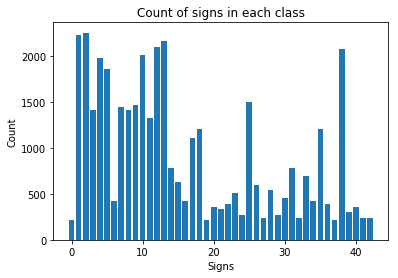

In [18]:
print('Smallest class: '+str(min(labels)))
print('Biggest class:  '+str(max(labels)))

classes = np.arange(len(labels))
plt.bar(classes, labels)
plt.xlabel('Signs')
plt.ylabel('Count')
plt.title('Count of signs in each class')
plt.show()

There are multiple ways to address it. One would be to add weights to loss function during training (for example https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss). However with over 10x difference between biggest and smallest classes, rare samples from small classes would be giving high error input to back propagation and the model might be difficult to train. <br>
Another approach could be data augmentation based on the loss. Traffic signs are good candidates for augmentation because we can apply some limited affine transformations or rotate by small angles. <br>
Ideally, the augmentation should be applied on training set to equalize class sizes. Before we do that let's take at one more aspect of the input data.

### Number of differnt sign "tracks"

As mentioned before signs images come from video tracks. Let's visualize the amount of tracks for each class. 

In [19]:
input_images_root = './source_data/train/GTSRB/Final_Training/Images'

def get_track_count(input_images_root):
    track_count = pd.DataFrame(columns=['class_id','track_count'])
    with os.scandir(input_images_root) as images_it:
        progress_bar = tqdm(range(43), desc='Counting tracks in each class')
        for class_id in images_it:
            if class_id.is_dir():# and class_id.name.startswith('00000'):
                with os.scandir(input_images_root+'/'+class_id.name) as class_it:
                    #print(input_images_root+'/'+class_id.name)
                    df = pd.DataFrame(columns=['name'])
                    for entry in class_it:
                        if entry.is_file() and entry.name.endswith('.ppm'):
                            df = df.append({'name':entry.name, 'track':entry.name[:entry.name.rfind("_")]}, ignore_index=True) 
                    track_count = track_count.append({'class_id':class_id.name, 'track_count':len(df.track.unique())}, ignore_index=True)        
            progress_bar.update()
    track_count = track_count.sort_values(by=['class_id'])
    return track_count

track_count = get_track_count(input_images_root)
track_count

,class_id,track_count
34,00000,7
32,00001,74
0,00002,75
9,00003,47
33,00004,66
18,00005,62
41,00006,14
35,00007,48
10,00008,47
26,00009,49


Lowest number of tracks per class: 7
Highest number of tracks per class:  75


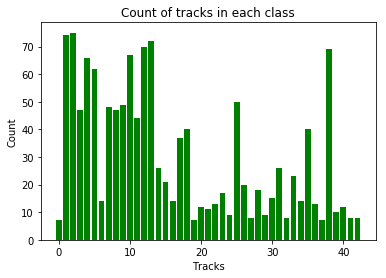

In [20]:
print('Lowest number of tracks per class: '+str(min(track_count['track_count'])))
print('Highest number of tracks per class:  '+str(max(track_count['track_count'])))

classes = np.arange(len(track_count['track_count']))
plt.bar(classes, track_count['track_count'], color='green')
plt.xlabel('Tracks')
plt.ylabel('Count')
plt.title('Count of tracks in each class')
plt.show()

### Data augmentation by reuse and rotation

Despite the overall size of the data set, when taking into account the correlation within tracks the data is smaller than it seems. As noticed by some researchers (for example [here](https://medium.com/@wolfapple/traffic-sign-recognition-2b0c3835e104), although the author made an error for the roundabout sign) it can be extended by rotating some signs or flipping and reusing for other class. For example left and right turn signs can be reused, and give way sign has horizontal symetry.<br>
<br>
Classes which can reuse images flipped horizontally from other class: (19,20), (33,34), (36,37), (38,39)<br>
Classes with horizontal symmetry: 11, 12, 13, 15, 17, 18, 22, 26, 30, 35<br>
Classes with vertical symmetry: 01, 05, 12, 15, 17<br>
Classes which can be rotated by 120 or 240 degrees: 40<br>
Classes which can be rotated by any degree: 15<br>
Classes which diagonal symetry : 32<br>
<br>
Let's create a new data source directory which will include reused images.<br> 
I'll also change classes to 2 digits in the new dataset.

In [21]:
# first copy all .ppm files to new location using new class names
input_images_root = './source_data/train/GTSRB/Final_Training/Images'
output_images_root = './source_data_2/train'

os.makedirs(output_images_root, exist_ok=True)
with os.scandir(input_images_root) as images_it:
    progress_bar = tqdm(range(43), desc='Copying files in each class')
    for class_id in images_it:
        if class_id.is_dir(): #and class_id.name.startswith('00000'):
            os.makedirs(output_images_root+'/'+class_id.name[-2:], exist_ok=True)
            with os.scandir(input_images_root+'/'+class_id.name) as class_it:
                #print(input_images_root+'/'+class_id.name)
                for entry in class_it:
                    if entry.is_file() and entry.name.endswith('.ppm'):
                        os.system('cp {} {}'.format(input_images_root+'/'+class_id.name+'/'+entry.name,
                                 output_images_root+'/'+class_id.name[-2:]+'/'+entry.name))  
            progress_bar.update()

In [22]:
# apply transforms

def transpose_image(image_path, save_path, transpose_1st=None, transpose_2nd=None, rotate_1st=None, rotate_2nd=None):
    """
    Transpose and rotate the given photo once or twice and save it
    @param image_path: The path to the input image
    @param transpose_1st: one of 
    @param transpose_2nd: one of 
        PIL.Image.FLIP_LEFT_RIGHT, 
        PIL.Image.FLIP_TOP_BOTTOM, 
        PIL.Image.ROTATE_90, 
        PIL.Image.ROTATE_180, 
        PIL.Image.ROTATE_270 or 
        PIL.Image.TRANSPOSE
    @param rotate_1st: degree to rotate, anti-clockwise 
    @param rotate_2nd: degree to rotate, anti-clockwise 
    @param save_path: Path to save the image
    """
    image_in = Image.open(image_path)
    if transpose_1st != None:
        image_out = image_in.transpose(transpose_1st)
        image_in = image_out 
    if transpose_2nd != None:
        image_out = image_in.transpose(transpose_2nd)
        image_in = image_out 
    if rotate_1st != None:
        image_out = image_in.rotate(rotate_1st)
        image_in = image_out 
    if rotate_2nd != None:
        image_out = image_in.rotate(rotate_2nd)
    image_out.save(save_path)



def transpose_class(class_id, prefix, transpose_1st=None, transpose_2nd=None, rotate_1st=None, rotate_2nd=None, together=True):
    with os.scandir(output_images_root+'/'+class_id) as class_it:
        if together:
            #apply both transforms or rotations to each file
            for entry in class_it:
                image_path = output_images_root+'/'+class_id+'/'+entry.name
                save_path = output_images_root+'/'+class_id+'/'+prefix+'_'+entry.name
#                print('{} -> {}'.format(image_path, save_path))
                transpose_image(image_path, save_path, transpose_1st=transpose_1st, transpose_2nd=transpose_2nd, rotate_1st=rotate_1st, rotate_2nd=rotate_2nd)
        else:
            #first create images with 1st transform/rotate and then second set of images with 2nd transform
            #iterators in Python run only once, so we save the input and creaet new iters for each loop
            files = list(class_it)
            for entry in iter(files):
                image_path = output_images_root+'/'+class_id+'/'+entry.name
                save_path = output_images_root+'/'+class_id+'/'+prefix+'_1_'+entry.name
#                print('{} -> {}'.format(image_path, save_path))
                transpose_image(image_path, save_path, transpose_1st=transpose_1st, rotate_1st=rotate_1st)
            for entry in iter(files):
                image_path = output_images_root+'/'+class_id+'/'+entry.name
                save_path = output_images_root+'/'+class_id+'/'+prefix+'_2_'+entry.name
#                print('{} -> {}'.format(image_path, save_path))
                transpose_image(image_path, save_path, transpose_2nd=transpose_2nd, rotate_2nd=rotate_2nd)


def duplicate_class_horizontally(class_id_1, class_id_2):
    class_it_1 = list(os.scandir(output_images_root+'/'+class_id_1))
    class_it_2 = list(os.scandir(output_images_root+'/'+class_id_2))
    for entry_1 in iter(class_it_1):
        os.system('cp {} {}'.format(output_images_root+'/'+class_id_1+'/'+entry_1.name,
                                    output_images_root+'/'+class_id_2+'/'+'from_'+class_id_1+'_'+entry_1.name))
    for entry_2 in iter(class_it_2):
        os.system('cp {} {}'.format(output_images_root+'/'+class_id_2+'/'+entry_2.name,
                                    output_images_root+'/'+class_id_1+'/'+'from_'+class_id_2+'_'+entry_2.name))
        
 

In [23]:

output_images_root = './source_data_2/train'
h_sym = ['11', '12', '13', '15', '17', '18', '22', '26', '30', '35']
v_sym = ['01', '05', '12', '15', '17']
r_120_240 = ['40', '15']
hv_flip = ['32']
h_duplicate = [['19','20'], ['33','34'], ['36','37'], ['38','39']]

#Test
#output_images_root = './source_data_3/train'
#h_sym = ['1']
#v_sym = ['2']
#r_120_240 = ['3', '4']
#hv_flip = ['5']
#h_duplicate = [['1','2'], ['3','4']]

progress_bar1 = tqdm(range(len(h_sym)), desc='Flipping horizontally')
for class_id in h_sym:
    transpose_class(class_id, prefix='hflip', transpose_1st=Image.FLIP_LEFT_RIGHT, together=True)
    progress_bar1.update()

progress_bar2 = tqdm(range(len(v_sym)), desc='Flipping vertically')
for class_id in v_sym:
    transpose_class(class_id, prefix='vflip', transpose_1st=Image.FLIP_TOP_BOTTOM, together=True)
    progress_bar2.update()

progress_bar3 = tqdm(range(len(r_120_240)), desc='Rotating')
for class_id in r_120_240:
    transpose_class(class_id, prefix='rot', rotate_1st=120, rotate_2nd=240, together=False)
    progress_bar3.update()

progress_bar4 = tqdm(range(len(hv_flip)), desc='Flipping horiz and vert')
for class_id in hv_flip:
    transpose_class(class_id, prefix='hv_flip', 
                    transpose_1st=Image.FLIP_LEFT_RIGHT, 
                    transpose_2nd=Image.FLIP_TOP_BOTTOM, together=True)
    progress_bar4.update()
    
progress_bar5 = tqdm(range(len(h_duplicate)), desc='Copying to symmetric class')
for pair in h_duplicate:
    duplicate_class_horizontally(pair[0], pair[1])  
    progress_bar5.update()

Let's check how class count looks after these changes

In [24]:
#Check data distribution

train_dataset_2 = datasets.ImageFolder('./source_data_2/train/')

Smallest class: 210
Biggest class:  13200


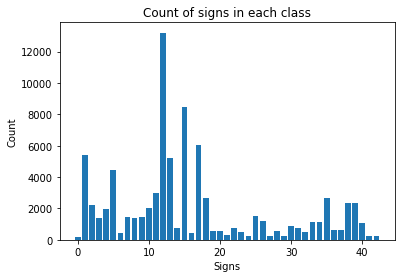

In [25]:
labels = np.zeros(len(train_dataset_2.classes))
progress_bar = tqdm(range(len(train_dataset_2)), desc='Counting files in each class')

for i in range(len(train_dataset_2)):
    x,y = train_dataset_2[i]
    labels[y] +=1
    progress_bar.update()
labels = np.array(labels, dtype=int)

print('Smallest class: '+str(min(labels)))
print('Biggest class:  '+str(max(labels)))

classes = np.arange(len(labels))
plt.bar(classes, labels)
plt.xlabel('Signs')
plt.ylabel('Count')
plt.title('Count of signs in each class')
plt.show()

We now have much more training data but some small classes didn't change, for example "20 speed limit". 
We should try to further augment the data set.

Lowest number of tracks per class: 7
Highest number of tracks per class:  1087


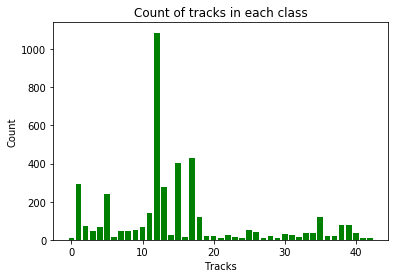

In [26]:
track_count = get_track_count('./source_data_2/train/')
print('Lowest number of tracks per class: '+str(min(track_count['track_count'])))
print('Highest number of tracks per class:  '+str(max(track_count['track_count'])))

classes = np.arange(len(track_count['track_count']))
plt.bar(classes, track_count['track_count'], color='green')
plt.xlabel('Tracks')
plt.ylabel('Count')
plt.title('Count of tracks in each class')
plt.show()

Split images into train and validation sets

In [27]:
train_images_root = './source_data_2/train/'
valid_images_root = './source_data_2/valid/'

def train_valid_split(train_images_root, valid_images_root, train_validation_ratio = 0.15):
    os.makedirs(valid_images_root, exist_ok=True)
    progress_bar_classes = tqdm(range(len(track_count)), desc='Extracting validation tracks')
    for index, row in track_count.iterrows():
        class_id = row['class_id']
        #select at least 2 tracks for validataion set
        valid_count= max(2,round(row['track_count'] * train_validation_ratio))
        os.makedirs(valid_images_root+class_id, exist_ok=True)
        with os.scandir(train_images_root + class_id) as images_it:
            images = list(images_it)
            images_tracks = pd.DataFrame(images)
            images_tracks['track'] = [image.name[:image.name.rfind("_")] for image in images_tracks[0]]
            sampled_track_list = random.sample(list(images_tracks['track']), valid_count)
            for sampled_track in iter(sampled_track_list):
                sampled_images=images_tracks[images_tracks['track']==sampled_track][0]
                for image in sampled_images:
                    os.system('mv {} {}'.format(train_images_root+class_id+'/'+image.name,
                                            valid_images_root+class_id+'/'+image.name))
        progress_bar_classes.update()
                    
train_valid_split(train_images_root, valid_images_root, train_validation_ratio = 0.15)

### Prepare test set

For test set we will use GTSRB Test set that we downloaded to source_data/test.
This dataset comprises of files all in one directory and a CSV file with Ground Truth labels.
We will copy it to the same file structure as /train and /valid sets, also using the same class names.

In [ ]:
test_images_input_path = './source_data/test/GTSRB/Final_Test/Images/'
test_lables_input_path = './source_data/test/GT-final_test.csv'
test_images_output_path  = './source_data_2/test/'

def prepare_test_data(test_images_input_path, test_lables_input_path, test_images_output_path):
    gt_data = pd.read_csv(test_lables_input_path, header=0, sep=';')
    gt_data['_00ClassId'] = gt_data.ClassId.astype(str).str.zfill(2)
    classes = pd.unique(gt_data['_00ClassId'])
    for class_id in pd.unique(gt_data['_00ClassId']):
        os.makedirs(test_images_output_path+class_id, exist_ok=True)

    progress_bar = tqdm(range(len(gt_data.index)), desc='Copying test classes')
    for index, row in gt_data.iterrows():
        class_id = row['_00ClassId']
        os.system('cp {} {}'.format(test_images_input_path+row['Filename'],
                                    test_images_output_path+class_id+'/'+row['Filename']))
        progress_bar.update()

        
prepare_test_data(test_images_input_path, test_lables_input_path, test_images_output_path)

### Augmentation though weighted transforms 

Traffic sign images can be augmented by appling affine transforms with small angles, say 20 degrees. The idea is to create more samples by transform calculate weights. I want to augment each class to 15000 samples

In [ ]:
train_data_transforms = transforms.Compose([
#    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2),
                                resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, 
                                resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), 
                                resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])

train_dataset_3 = datasets.ImageFolder('./source_data_2/train/', transform = train_data_transforms)


In [ ]:
weights = np.zeros(len(train_dataset_2.classes))
for i in range(len(train_dataset_2.classes)):
    weights[i] = 1/labels[i]
    
sampler = WeightedRandomSampler(weights, 43 * 15000)
train_loader = DataLoader(train_dataset_3, batch_size=1, sampler=sampler)

In [ ]:
#for test_images, test_labels in train_loader:  
#    sample_image = test_images[0]    # Reshape them according to your needs.
#    sample_label = test_labels[0]
    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

### Grayscale

GTSRB dataset has been used in competitions and by many ML researchers. One team (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) discovered that CNN networks train better when color information is removed. I would like to try that as well. Transformation to grayscale can be applied by PyToarch transforms. 